In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import dismech_jax

In [ ]:
from dataclasses import dataclass
from jax.tree_util import register_dataclass

@register_dataclass
@dataclass
class MyTriplet(dismech_jax.Triplet):

    @jax.jit
    def get_K(self, strain: jax.Array) -> jax.Array:
        return strain ** 2 * jnp.array([[40]])

def get_random_der_triplet(seed: int = 42) -> dismech_jax.DERTriplet:
    # Initial state
    key = jax.random.key(seed)
    EA = jax.random.uniform(key)
    x0 = jax.random.uniform(key, [9])
    ini_state = dismech_jax.State(x0)
    l_0 = jnp.linalg.norm(x0[0:3] - x0[3:6])
    l_1 = jnp.linalg.norm(x0[3:6] - x0[6:9])
    return dismech_jax.DERTriplet.init(
        jnp.array([0,1,2]),
        jnp.array([l_0, l_1]),
        jnp.array([0.0]),
        jnp.array([EA]),
        jnp.array([0, 0]),
        jnp.array([0]),
        ini_state,
    )

def get_random_my_triplet(seed: int = 42) -> MyTriplet:
    # Initial state
    key = jax.random.key(seed)
    EA = jax.random.uniform(key)
    x0 = jax.random.uniform(key, [9])
    ini_state = dismech_jax.State(x0)
    l_0 = jnp.linalg.norm(x0[0:3] - x0[3:6])
    l_1 = jnp.linalg.norm(x0[3:6] - x0[6:9])
    return MyTriplet.init(
        jnp.array([0,1,2]),
        jnp.array([l_0, l_1]),
        jnp.array([0.0]),
        ini_state,
    )

def test_energy_stretch_linear_elastic(triplet: dismech_jax.stencils.triplet.BaseTriplet, seed: int = 10):
    # Deformed state
    x = jax.random.uniform(jax.random.key(seed), [9])
    state = dismech_jax.State(x)
    grad, hess = triplet.get_grad_hess_energy(state)
    energy_ground = triplet.get_energy(state)

    # FDM
    change = 1e-5
    grad_fdm = jnp.zeros_like(x)
    hess_fdm = jnp.zeros((x.shape[0], x.shape[0]))

    for c in range(x.shape[0]):
        x_plus = x.at[c].add(change)
        state_plus = dismech_jax.State(x_plus)

        energy_plus = triplet.get_energy(state_plus)
        grad_fdm = grad_fdm.at[c].set((energy_plus - energy_ground) / change)

        grad_change = triplet.get_grad_energy(state_plus)
        hess_fdm = hess_fdm.at[:, c].set((grad_change - grad) / change)

    # Plot gradients
    plt.figure(1)
    plt.plot(grad, 'ro', label='Analytical')
    plt.plot(grad_fdm, 'b^', label='Finite Difference')
    plt.legend(); plt.xlabel('Index'); plt.ylabel('Gradient')
    plt.title('Forces (Gradients) Comparison')
    plt.show()

    # Plot Hessians
    plt.figure(2)
    plt.plot(hess.flatten(), 'ro', label='Analytical')
    plt.plot(hess_fdm.flatten(), 'b^', label='Finite Difference')
    plt.legend(); plt.xlabel('Index'); plt.ylabel('Hessian')
    plt.title('Hessian Comparison')
    plt.show()

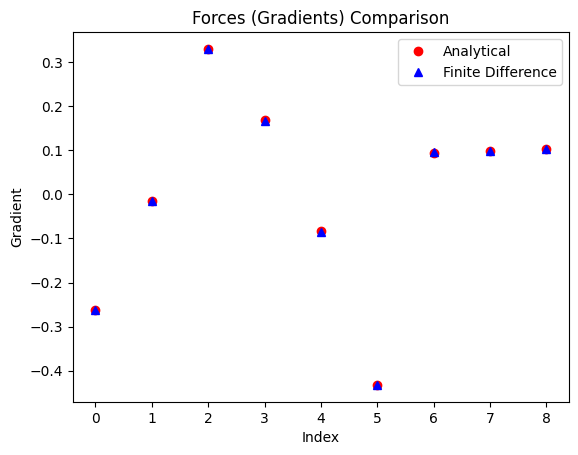

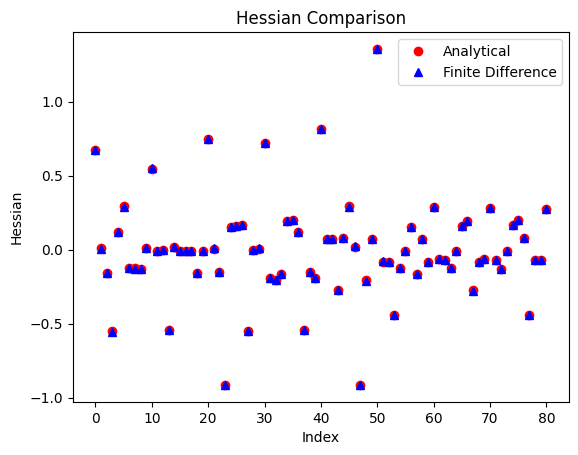

In [ ]:
test_energy_stretch_linear_elastic(get_random_der_triplet())

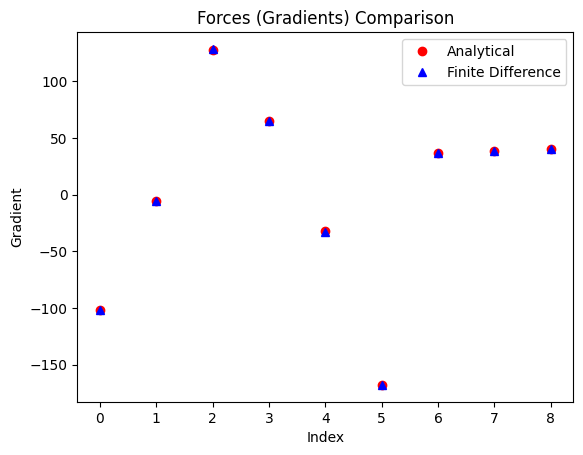

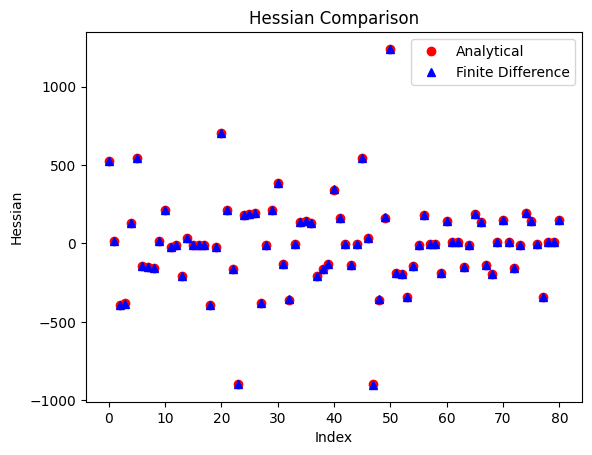

In [16]:
test_energy_stretch_linear_elastic(get_random_my_triplet())